In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
from pdb import set_trace

In [4]:
PATH = Path('data/pascal-voc/')

Path returns a path object

In [5]:
list(PATH.iterdir())

[PosixPath('data/pascal-voc/pascal_train2007.json'),
 PosixPath('data/pascal-voc/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal-voc/pascal_test2007.json'),
 PosixPath('data/pascal-voc/pascal_val2012.json'),
 PosixPath('data/pascal-voc/VOCdevkit'),
 PosixPath('data/pascal-voc/pascal_train2012.json'),
 PosixPath('data/pascal-voc/pascal_val2007.json')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

In [6]:
!ls data/pascal-voc/

pascal_test2007.json   pascal_val2007.json  VOCtrainval_06-Nov-2007.tar
pascal_train2007.json  pascal_val2012.json
pascal_train2012.json  VOCdevkit


Loading annotations for training data

In [7]:
f = (PATH/'pascal_train2007.json').open()

In [8]:
f

<_io.TextIOWrapper name='data/pascal-voc/pascal_train2007.json' mode='r' encoding='UTF-8'>

In [9]:
trn_j = json.load(f)

In [10]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [11]:
images, types, annotations, categories = ['images', 'type', 'annotations', 'categories']

In [12]:
images

'images'

In [13]:
type(trn_j[images])

list

In [14]:
len(trn_j[images])

2501

In [15]:
trn_j[images][0]

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}

In [16]:
trn_j[types][0]

'i'

In [17]:
trn_j[annotations][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

The bounding box in default is: 155 x coordinate, 96 y coordinate and the box is 174 is the height and 196 is the width of the box

In [18]:
trn_j[categories][0]

{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'}

In [19]:
cats_list = dict((o['id'], o['name']) for o in trn_j[categories])

In [20]:
cats_list

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

So we have 20 object categories

Storing image filename along with it's ID

In [21]:
trn_fn = dict((o['id'], o['file_name']) for o in trn_j[images])

In [22]:
trn_id = [e['id'] for e in trn_j[images]]

In [23]:
imgs = 'VOCdevkit/VOC2007/JPEGImages'

In [24]:
imgs_path = PATH/imgs

In [25]:
list(imgs_path.iterdir())[0]

PosixPath('data/pascal-voc/VOCdevkit/VOC2007/JPEGImages/000671.jpg')

Switching the bounding box dimensions in numpy format with upper left and lower right coordinates

In [26]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[annotations]:
    if not o['ignore']:
        bb = o['bbox']
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o['image_id']].append((bb,o['category_id']))
        
len(trn_anno)

2501

In [27]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [28]:
cats_list[7]

'car'

In [29]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

This image has 2 bounding boxes

In [30]:
cats_list[15],cats_list[13]

('person', 'horse')

In [31]:
def bb_hw(bb_ul):
    return np.array([bb_ul[1], bb_ul[0], bb_ul[3] - bb_ul[1]+1, bb_ul[2] - bb_ul[0]+1])

In [32]:
trn_anno[12][0][0]

array([ 96, 155, 269, 350])

In [33]:
bb_hw(trn_anno[12][0][0])

array([155,  96, 196, 174])

In [34]:
im0_d = trn_j[images][0]
im0_d['file_name'],im0_d['id']

('000012.jpg', 12)

In [35]:
im = open_image(imgs_path/im0_d['file_name'])

In [36]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [37]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [38]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [39]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [40]:
im_a = trn_anno[im0_d['id']]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [41]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

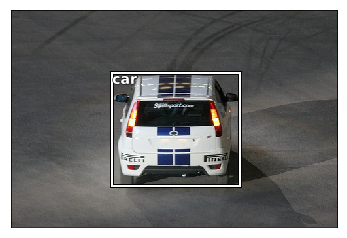

In [42]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats_list[im0_a[1]])

In [43]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats_list[c], sz=16)

In [44]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(imgs_path/trn_fn[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


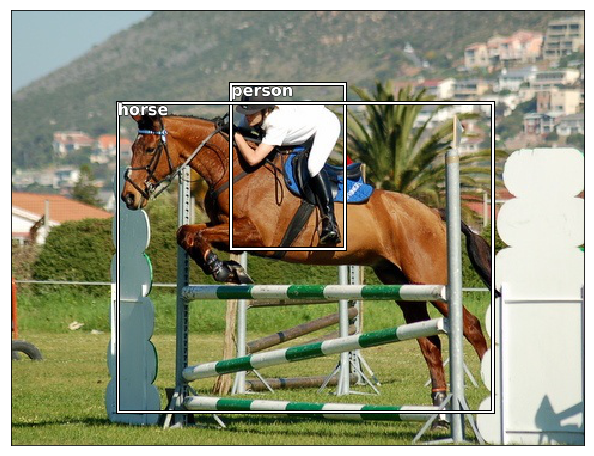

In [45]:
draw_idx(17)

## Largest item classifier

### Getting bounding box for the largest object in the image

In [46]:
trn_anno[17]  #for each image_id the corresponding annotations for each object

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [47]:
b_tmp  = trn_anno[17][0]

In [48]:
lr = b_tmp[0][-2:] #last 2 elements denoting lower right corner

In [49]:
ul = b_tmp[0][:2] #first 2 elements denoting upper left corner

In [50]:
ul-lr

array([-137,  -94])

In [51]:
np.product(ul-lr) #area calculation

12878

Use of lambda function in sorting list

In [52]:
l = [(1,5),(6,7)]

Now we want to sort based on the sum of each tuple

In [53]:
sorted(l,key=lambda x: x[0]+x[1], reverse=True) #here x refers to each element of the list

[(6, 7), (1, 5)]

In [54]:
#finds the bounding box for the largest object in the image
def get_lrg(b):
#     set_trace()
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [55]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

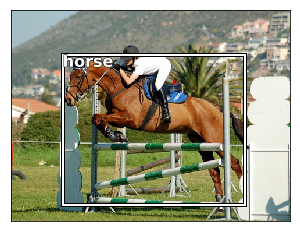

In [59]:
b,c = trn_lrg_anno[17]
b = bb_hw(b)
ax = show_img(open_image(imgs_path/trn_fn[17]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats_list[c], sz=16)

As we can see horse is the largest object in this picture as opposed to person